In [2]:
import SimpleITK as sitk
import glob
import os
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
with open(os.getcwd()+'/data/df50.p','rb') as f:
    df50 = pd.read_pickle(f)

In [5]:
df50.head()

,PID,gender,age,vessel,seg,ffr,ffr_80,n_frame,OS,distal,lu,pl,luA,plA,luAt,plAt
0,F0002,1,59,1,1,0.83,0,2381,2152,91,"[4517, 4831, 4237, 4625, 4818, 5136, 4808, 479...","[2329, 2337, 3093, 3639, 4299, 4032, 2820, 309...","[5.65995771008, 6.05341060381, 5.30910799593, ...","[2.91831780092, 2.92834207847, 3.87563630668, ...","[7.87908215209, 7.30519226251, 9.25616728013, ...","[2.80303860913, 4.09491737802, 5.35421724489, ..."
1,F0003,2,73,1,2,0.91,0,3642,3097,551,"[3705, 3767, 4139, 4650, 4692, 4526, 4548, 423...","[3038, 2923, 2509, 1992, 2036, 2141, 2291, 254...","[5.21015625, 5.29734375, 5.82046875, 6.5390625...","[4.2721875, 4.11046875, 3.52828125, 2.80125, 2...","[5.7515625, 6.03984375, 6.18328125, 4.9078125,...","[3.915, 3.6590625, 3.4509375, 4.71234375, 3.93..."
2,F0004,1,61,1,2,0.72,1,4060,3463,261,"[769, 800, 754, 832, 831, 879, 857, 843, 835, ...","[7839, 7463, 6465, 6451, 7254, 7010, 7309, 676...","[1.08140625, 1.125, 1.0603125, 1.17, 1.1685937...","[11.02359375, 10.49484375, 9.09140625, 9.07171...","[4.4465625, 4.1484375, 4.07671875, 4.460625, 4...","[3.56625, 3.99515625, 4.381875, 3.6703125, 4.2..."
3,F0005,1,61,3,2,0.83,0,3970,3883,285,"[2829, 2329, 2576, 2391, 2936, 2931, 3041, 307...","[3025, 4145, 3621, 3865, 3048, 3062, 2879, 345...","[3.97828125, 3.27515625, 3.6225, 3.36234375, 4...","[4.25390625, 5.82890625, 5.09203125, 5.4351562...","[6.80484375, 6.53203125, 6.654375, 6.52640625,...","[4.47609375, 4.52671875, 4.40578125, 4.4564062..."
4,F0007,1,60,1,2,0.85,0,2813,2610,465,"[4183, 4130, 4314, 4506, 4544, 4566, 4589, 446...","[1852, 1927, 2007, 1891, 1963, 1900, 1917, 209...","[5.88234375, 5.8078125, 6.0665625, 6.3365625, ...","[2.604375, 2.70984375, 2.82234375, 2.65921875,...","[6.77671875, 6.93703125, 7.29984375, 7.3575, 7...","[3.34265625, 3.44390625, 2.88140625, 3.11625, ..."


In [6]:
def windowed_mean(y,w):
    """
    window size = w
    step size = w/2
    """
    ymm=[]
    for j in range(len(y))[0:len(y):int(w/2)]:
        if len(y[j:j+w])==w:
            ymm.append(y[j:j+w].mean())
    return ymm
    
df50['luA_wm10'] = df50['luA'].apply(lambda x: windowed_mean(x,10)) # windowed mean lumen area with window=10
df50['luAt_wm10'] = df50['luAt'].apply(lambda x: windowed_mean(x,10)) # windowed mean lumen area in ROI with window=10
df50['mlat'] = df50['luAt'].apply(lambda x: min(x)) # minimum lumen area in ROI
df50['mlat_wm10'] = df50['luAt_wm10'].apply(lambda x: min(x)) #MLA (minimum lumen area) from windowed mean in ROI
z = df50['luA'].apply(lambda x: np.arange(len(x))) # a dummy variable for frame for plot
z_wm10 = df50['luA'].apply(lambda x: windowed_mean(np.arange(len(x)),10)) # a dummy variable for the windowed frame for plot
z_mlat = df50['distal']+df50['luAt'].apply(lambda x: np.argmin(x)) # z for MLA from ROI
z_mlat_wm10 = df50['distal']+df50['luAt_wm10'].apply(lambda x: 5+5*np.argmin(x)) # z for MLA from ROI when we take windowed mean for lumen area

In [7]:
len(z[1]), len(z_wm10[1]),len(df50['lu'][1])

(3642, 727, 3642)

In [196]:
#### FEATURES 1-2
def plaqueburden(lu,pl):
    """
    lu, pl: lists
    returns plaque burden
    """
    x = np.array(lu)
    y = np.array(pl)
    return y/(x + y)
    
def lesion(pb,th,gap):
    """
    pb: plaqueburden list
    th: threshold (.4, .7)
    gap: number of frames to ignore with pb below threshold in lesion
    returns nested list with each lesions start, end, and length
    """
    
    index = np.where(pb > th)[0]
    
    runs = []
    start = index[0]
    count = 0 
    end = []
    for i in index:
        if i == (start + count): 
            end = i
        elif i - end - 1 < gap:
            end = i
        else:
            runs.append([start,end,end-start+1])
            start = i
            end = i
            count = 0
        
        #print(i, count, start, end)
        count +=1
    runs.append([start,end,end-start+1])
    
    return runs

In [176]:
test = np.array([0.5, 0.5, 0.2, 0.2, 0.2, 0.5, 0.5, 0.2, 0.5])
lesion(test,0.4,10)

0 0 0 0
1 1 0 1
5 2 0 5
6 3 0 6
8 4 0 8


[[0, 8, 9]]

In [223]:
### validate df50 record F0002
PB = plaqueburden(df50.loc[0].luA,df50.loc[0].plA)
lesionlst = np.array(lesion(PB,0.4,300))
lesionlst

array([[   2,  467,  466],
       [ 828, 2380, 1553]])

In [259]:
#### FEATURES 3-5
def mla(luA,distal,os):
    """
    luA: list of lumen area mm2
    distal: roi distal
    os: roi ostium 
    returns minimum luA value
    """
    roi = luA[distal:os] 
    return min(roi)

def fromos_pb(pb,th,gap,os): 
    """
    pb: plaqueburden list
    th: threshold (0.4, 0.7)
    gap: number of frames to ignore with pb below threshold in lesion
    os: roi ostium
    returns distance from OS to farthest right lesion proximal site
    """
    lesionlist = lesion(pb,th,gap)
    lesionproximal = lesionlst[:,1][-1] #ignores multiple lesions in roi and only uses farthest right lesion
    print(lesionproximal,os)
    return (os - lesionproximal) #if negative the lesion is on outside of roi ostium

def fromos_mla(luA,distal,os): 
    
    indexmla = np.where(luA == mla(luA,distal,os)) #without smoothing this could return multiple mla indexes when mla = 0
    print(indexmla,os)
    return (os - indexmla)[0]

In [258]:
fromos_mla(test,df50.loc[0].distal,df50.loc[0].OS)

[1641] 2152


511

In [301]:
#### FEATURES 6-11
def mla(luA,distal,os):
    """
    luA: list of lumen area mm2
    distal: roi distal
    os: roi ostium 
    returns minimum mla value in roi
    """
    roi = luA[distal:os] 
    return min(roi)

def eem_mla(luA,plA,distal,os):
    """
    luA,plA: list of lumen area and plaque area mm2
    distal: roi distal
    os: roi ostium 
    returns eem mm2 at mla within roi
    """
    indexmla = np.where(luA == mla(luA,distal,os))
    x = np.array(luA)
    y = np.array(plA)
    eem = x + y
    return eem[indexmla][0]

def pb_mla(luA,plA,distal,os):
    """
    luA,plA: list of lumen area and plaque area mm2
    distal: roi distal
    os: roi ostium 
    returns plaqueburden mm2 at mla in roi
    """
    indexmla = np.where(luA == mla(luA,distal,os))
    pb = plaqueburden(luA,plA)
    return pb[indexmla][0]

def max_pb(luA,plA,distal,os):
    """
    luA,plA: list of lumen area and plaque area mm2
    distal: roi distal
    os: roi ostium 
    returns max plaqueburden mm2 in roi
    """
    pb = plaqueburden(luA,plA)
    roi = pb[distal:os]
    return max(roi)

def numberofpb(pb,th,distal,os):
    """
    pb: plaqueburden list
    th: threshold (0.4, 0.7)
    distal: roi distal
    os: roi ostium 
    returns number of frames with pb > threshold
    """
    roi = pb[distal:os]
    index = np.where(roi > th)[0]
    return len(index)


In [306]:
# example values for testing
luA = df50.loc[0].luA
plA = df50.loc[0].plA
distal = df50.loc[0].distal
os = df50.loc[0].OS

In [310]:
x = np.array(luA[distal:os])
y = np.array(plA[distal:os])
pb = y/(x + y)

In [314]:
roi = np.array(luA[distal:os])
numlua = np.where(roi < .7)

In [315]:
numlua

(array([1550]),)

In [329]:
lst1 = np.array([1,2,3,4,5,6])
lst2 = [3,4,7,8,9,3]

In [331]:
Intersection(lst1,lst2)

{3, 4}

In [326]:
#### FEATURES 12-38
### Combined features 12-38 by including a plaque burden threshold parameter. 
### this asumes the features are within the ROI. It wasn't defined in the variables_def.xlsx
### similar to features 12-20 which clearly defined within ROI region


def Intersection(lst1, lst2):
    """
    lst1,lst2: list
    returns the intersection (common frames) between two lists
    """
    return set(lst1).intersection(lst2)


def no_lumen_roi(luA,plA,distal,os,th,pbth=1):
    """
    luA,plA: list of lumen/plaque area mm2
    distal: roi distal
    os: roi ostium
    th: threshold (4,3,2.5)
    pbth: plaqueburden threshold (1-default,0.7,0.4)
    returns number of frames greater than thresh in roi
    """
    roi = np.array(luA[distal:os])
    numlua = np.where(roi < th)
    
    if pbt != 1:
        x = np.array(luA[distal:os])
        y = np.array(plA[distal:os])
        pb = y/(x + y)
        pb2 = np.where(pb > pbth)
        numlua = list(Intersection(numlua,pb2))
        
    return len(numlua)

def sum_plaque_roi(luA,plA,distal,os,pbth=1):
    """
    plA: list of plaque area mm2
    distal: roi distal
    os: roi ostium
    returns the total plaque area mm2 in roi
    """
    if pbth == 1:
        roi = np.array(plA[distal:os])
    else:
        x = np.array(luA[distal:os])
        y = np.array(plA[distal:os])
        pb = y/(x + y)
        pb2 = np.where(pb > pbth)
        roi = roi[pb2]
        
    return sum(roi)
    
def sum_eem_roi(luA,plA,distal,os,pbth=1):
    """
    luA, plA: list of lumen/plaque area mm2
    distal: roi distal
    os: roi ostium
    pbth: plaqueburden threshold (1-default,0.4,0.7)
    returns the total eem area mm2 in roi
    """
    x = np.array(luA[distal:os])
    y = np.array(plA[distal:os])
    if pbth == 1:
        eem = sum(x + y)
    else:
        pb = y/(x + y)
        pb2 = np.where(pb > pbth)
        eem = sum(x[pb2] + y[pb2])
        
    return eem
    
def pb_roi(luA,plA,distal,os,pbth=1):
    """
    luA, plA: list of lumen/plaque area mm2
    distal: roi distal
    os: roi ostium
    pbth: plaqueburden threshold (1-default,0.4,0.7)
    returns the overall plaqueburden in roi
    """
    plsum = sum_plaque_roi(luA,plA,distal,os,pbth)
    eemsum = sum_eem_roi(luA,plA,distal,os,pbth)
    pb = plsum/eemsum
    
    return pb

def mean_lumen_roi(lu,pl,distal,os,pbth=1):
    """
    lu: list of lumen area
    distal: roi distal
    os: roi ostium
    pbth: plaqueburden threshold (1-default,0.4,0.7)
    returns the mean lumen in roi
    """
    roi = lu[distal:os]
    
    if pbt != 1:
        x = np.array(luA[distal:os])
        y = np.array(plA[distal:os])
        pb = y/(x + y)
        pb2 = np.where(pb > pbth)
        roi = roi[pb2]
        
    return mean(roi)


def mean_plaque_roi(pl,distal,os,pbth=1):
    """
    lu: list of plaque area
    distal: roi distal
    os: roi ostium
    pbth: plaqueburden threshold (1-default,0.4,0.7)
    returns the mean plaque in roi
    """
    roi = pl[distal:os]
    
    if pbt != 1:
        x = np.array(luA[distal:os])
        y = np.array(plA[distal:os])
        pb = y/(x + y)
        pb2 = np.where(pb > pbth)
        roi = roi[pb2]
    
    return mean(roi) 

def mean_eem_roi(pl,distal,os,pbth=1):
    """
    lu,pl: list
    distal: roi distal
    os: roi ostium
    pbth: plaqueburden threshold (1-default,0.4,0.7)
    returns the mean eem in roi
    """
    x = np.array(lu[distal:os])
    y = np.array(pl[distal:os])
    roi = x + y
    
    if pbt != 1:
        x = np.array(luA[distal:os])
        y = np.array(plA[distal:os])
        pb = y/(x + y)
        pb2 = np.where(pb > pbth)
        roi = roi[pb2]
        
    return mean(roi)

In [332]:
import time


In [373]:
t0 = time.time()
y = df50['luA'].apply(lambda x: windowed_mean(x,15))
t1 = time.time()

total = t1-t0
print(total)

0.2634718418121338


In [345]:
import scipy
from scipy.signal import savgol_filter

In [382]:
t0 = time.time()
y2 = df50['luA'].apply(lambda x: savgol_filter(x, 99, 3))
t1 = time.time()

total = t1-t0
print(total)

0.05038189888000488


In [359]:
df50['luA'][0]

array([ 5.65995771,  6.0534106 ,  5.309108  , ...,  1.86827473,
        2.1777743 ,  1.91463701])

In [354]:
y2

0     [5.78222351956, 5.64406695192, 5.68410439379, ...
1     [5.00066761364, 5.61573153409, 6.02605215097, ...
2     [1.08734375, 1.09175426136, 1.11379159903, 1.1...
3     [3.91146306818, 3.46934659091, 3.40265929383, ...
4     [5.79903409091, 5.95372159091, 6.10323762175, ...
5     [4.32888047204, 4.783542212, 4.88257806012, 4....
6     [9.27346590909, 9.84225142045, 10.3896387987, ...
7     [6.26095170455, 6.24143465909, 6.13861099838, ...
8     [6.59978693182, 6.58246448864, 6.45771002435, ...
9     [4.2342447104, 4.84648505574, 5.22460861595, 5...
10    [2.63641030874, 3.01625068921, 3.21800826022, ...
11    [3.56917613636, 3.31490056818, 3.26721286526, ...
12    [6.22401988636, 6.23137073864, 6.21615158279, ...
13    [5.99204545455, 5.92407670455, 5.90628855519, ...
14    [6.06971271174, 6.611821085, 6.89151361686, 6....
15    [10.6693499329, 11.8669283484, 12.5244054159, ...
16    [7.92367897727, 8.062109375, 8.09608461851, 8....
17    [8.53388770626, 8.59589393821, 8.544476120

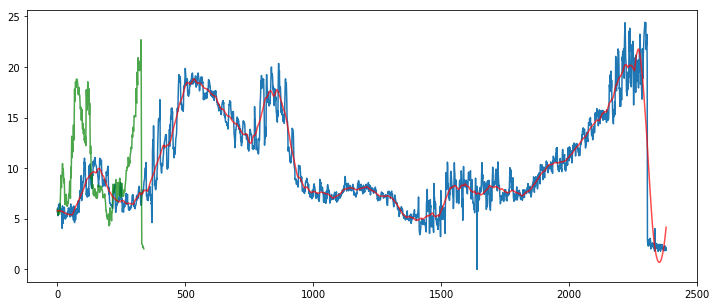

In [383]:
plt.figure(figsize=(12,5))
plt.plot(df50['luA'][0])
plt.plot(y[0],color='green',alpha=0.7)
plt.plot(y2[0],color='red',alpha=0.7)

In [367]:
len(y[0]),len(df50['luA'][0]),len(y2[0])

(475, 2381, 2381)